<a href="https://colab.research.google.com/github/JorgeZarama/TFM-final-models/blob/main/Dashboard_Predicci%C3%B3n_de_Precios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importar Librería

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Attention, Layer, Input, Dropout, concatenate
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.callbacks import EarlyStopping
from sklearn import preprocessing
from tensorflow.keras.optimizers import Adam


## Extracción de Datos


In [ ]:
def obtener_rango_fechas(symbol):
    """
    Obtiene las fechas más antigua y más reciente disponibles para una acción específica desde Yahoo Finance.
    """
    # Descargar datos con un intervalo grande para obtener el rango completo de fechas
    data = yf.download(symbol, period="max", interval='1d')
    data.reset_index(inplace=True)
    fecha_inicio = data['Date'].min()
    fecha_fin = data['Date'].max()
    return fecha_inicio, fecha_fin

def descargar_datos_accion(symbol, interval='1d'):
    """
    Descarga datos históricos de una acción desde Yahoo Finance en el rango más amplio posible.

    Args:
    symbol (str): Símbolo de la acción (por ejemplo, 'GOOGL').
    interval (str): Intervalo de los datos (por defecto, '1d').

    Returns:
    pd.DataFrame: Datos históricos de la acción.
    """
    # Obtener rango dinámico de fechas
    fecha_inicio, fecha_fin = obtener_rango_fechas(symbol)

    # Descargar datos
    df = yf.download(symbol, start=fecha_inicio.strftime('%Y-%m-%d'),
                     end=fecha_fin.strftime('%Y-%m-%d'), interval=interval)
    df.reset_index(inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    return df
def mostrar_informacion(df):
    """
    Muestra estadísticas descriptivas e información básica del DataFrame.
    """
    display(df.describe(include='all'))
    display(df.info())
    print("Primeras filas del DataFrame:")
    print(df.head())
    print("\nÚltimas filas del DataFrame:")
    print(df.tail())

# Ejemplo de uso

def obtener_rango_fechas(symbol):
    """
    Obtiene las fechas más antigua y más reciente disponibles para una acción específica desde Yahoo Finance.
    """
    data = yf.download(symbol, period="max", interval='1d')
    data.reset_index(inplace=True)
    fecha_inicio = data['Date'].min()
    fecha_fin = data['Date'].max()
    return fecha_inicio, fecha_fin

def descargar_datos_accion(symbol, interval='1d'):
    """
    Descarga datos históricos de una acción desde Yahoo Finance en el rango más amplio posible.
    """
    fecha_inicio, fecha_fin = obtener_rango_fechas(symbol)
    df = yf.download(symbol, start=fecha_inicio.strftime('%Y-%m-%d'),
                     end=fecha_fin.strftime('%Y-%m-%d'), interval=interval)
    df.reset_index(inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    return df

def graficar_precio_cierre(df, symbol):
    """
    Genera un gráfico de línea para la evolución del precio de cierre de una acción.
    Calcula automáticamente el rango de fechas del DataFrame.
    """
    # Rango dinámico de fechas desde el DataFrame
    fecha_inicio = df['Date'].min().strftime('%Y-%m-%d')
    fecha_fin = df['Date'].max().strftime('%Y-%m-%d')

    print(f"Rango de fechas: {fecha_inicio} a {fecha_fin}")

    # Crear el gráfico
    plt.figure(figsize=(20, 6))
    sns.lineplot(x='Date', y='Close', data=df)

    # Personalizar el eje x para mostrar meses y años
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45)

    # Agregar título y etiquetas
    plt.title(f"Evolución del Precio de Cierre ({symbol})\n{fecha_inicio} a {fecha_fin}")
    plt.xlabel('Fecha')
    plt.ylabel('Precio de Cierre')

    # Cuadrícula
    plt.grid(True, linestyle='--', alpha=0.7)

    # Mostrar el gráfico
    plt.show()


Procesando la acción: TSM


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Información de los datos para TSM:


,Date,Open,High,Low,Close,Adj Close,Volume
count,6820,6820.000000,6820.000000,6820.000000,6820.000000,6820.000000,6.820000e+03
mean,2011-04-29 13:51:54.369501440,32.025355,32.395942,31.626650,32.007705,27.543479,9.831546e+06
min,1997-10-09 00:00:00,3.028934,3.159125,2.842947,3.082074,1.555490,1.602820e+05
25%,2004-07-22 18:00:00,9.495268,9.631841,9.351302,9.485503,5.051428,5.746800e+06
50%,2011-04-28 12:00:00,13.805000,13.979565,13.603591,13.779792,8.943067,8.648556e+06
75%,2018-02-06 06:00:00,38.047501,38.362500,37.832501,38.104999,32.558723,1.253688e+07
max,2024-11-14 00:00:00,205.949997,212.600006,201.970001,205.839996,205.839996,6.227470e+07
std,NaN,38.121426,38.579160,37.599684,38.073074,38.256315,6.314935e+06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6820 entries, 0 to 6819
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       6820 non-null   datetime64[ns]
 1   Open       6820 non-null   float64       
 2   High       6820 non-null   float64       
 3   Low        6820 non-null   float64       
 4   Close      6820 non-null   float64       
 5   Adj Close  6820 non-null   float64       
 6   Volume     6820 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 373.1 KB


None

C:\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Primeras filas del DataFrame:
        Date      Open      High       Low     Close  Adj Close    Volume
0 1997-10-09  5.646040  6.562691  5.646040  6.323565   3.191437  10201979
1 1997-10-10  7.014374  7.040944  6.363419  6.615830   3.338940  10669148
2 1997-10-13  6.629115  6.629115  6.443128  6.469698   3.265188   3044363
3 1997-10-14  6.416558  6.429843  6.031299  6.204002   3.131095   2549907
4 1997-10-15  5.818742  6.044584  5.805458  6.031299   3.043932   3167153

Últimas filas del DataFrame:
           Date        Open        High         Low       Close   Adj Close  \
6815 2024-11-08  203.889999  206.610001  200.020004  201.199997  201.199997   
6816 2024-11-11  197.960007  198.199997  191.490005  194.050003  194.050003   
6817 2024-11-12  193.830002  194.000000  189.720001  191.770004  191.770004   
6818 2024-11-13  192.440002  192.479996  186.500000  186.660004  186.660004   
6819 2024-11-14  188.399994  192.660004  187.539993  188.500000  188.500000   

        Volume  
6815

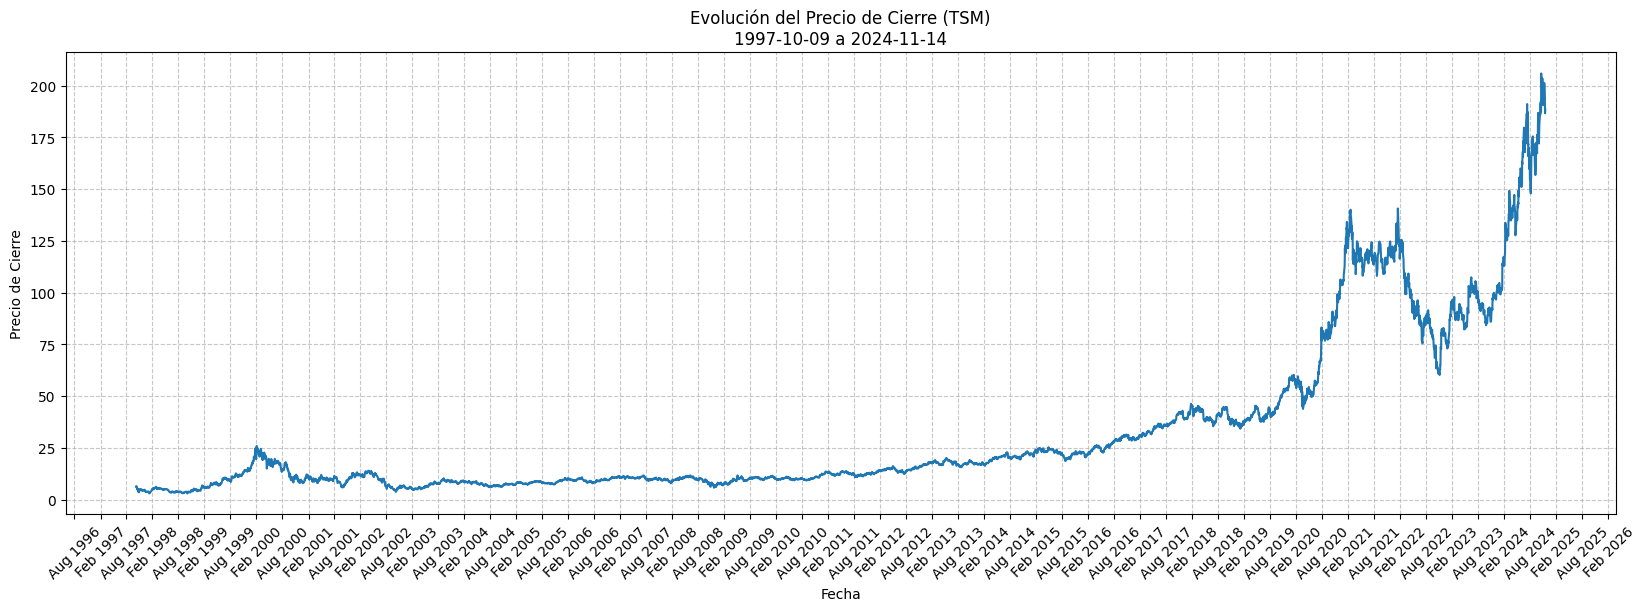


Procesando la acción: ASML


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Información de los datos para ASML:


,Date,Open,High,Low,Close,Adj Close,Volume
count,7471,7471.000000,7471.000000,7471.000000,7471.000000,7471.000000,7.471000e+03
mean,2010-01-12 06:03:07.926649600,147.880131,149.549741,146.083244,147.864056,138.692721,2.015020e+06
min,1995-03-15 00:00:00,1.875000,2.144531,1.828125,2.109375,1.298926,1.066700e+04
25%,2002-08-13 12:00:00,18.838125,19.080000,18.584999,18.826876,11.735715,8.414000e+05
50%,2010-01-13 00:00:00,34.919998,35.296875,34.500000,34.919998,23.496899,1.503022e+06
75%,2017-06-14 12:00:00,133.974998,134.924995,133.509995,134.184998,125.112148,2.600534e+06
max,2024-11-14 00:00:00,1109.979980,1110.089966,1075.829956,1098.949951,1094.377319,9.264640e+07
std,NaN,232.135662,234.755892,229.180205,232.035150,230.421774,2.114362e+06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7471 entries, 0 to 7470
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       7471 non-null   datetime64[ns]
 1   Open       7471 non-null   float64       
 2   High       7471 non-null   float64       
 3   Low        7471 non-null   float64       
 4   Close      7471 non-null   float64       
 5   Adj Close  7471 non-null   float64       
 6   Volume     7471 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 408.7 KB


None

C:\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Primeras filas del DataFrame:
        Date      Open      High       Low     Close  Adj Close    Volume
0 1995-03-15  1.875000  2.144531  1.828125  2.109375   1.298926  92646400
1 1995-03-16  2.320313  2.390625  2.226563  2.320313   1.428819  22867200
2 1995-03-17  2.332031  2.332031  2.226563  2.238281   1.378305  17163733
3 1995-03-20  2.226563  2.238281  2.179688  2.226563   1.371089   7141333
4 1995-03-21  2.226563  2.355469  2.203125  2.332031   1.436035   8198400

Últimas filas del DataFrame:
           Date        Open        High         Low       Close   Adj Close  \
7466 2024-11-08  670.000000  671.239990  661.890015  669.469971  669.469971   
7467 2024-11-11  671.770020  671.989990  661.940002  671.309998  671.309998   
7468 2024-11-12  672.640015  676.539978  662.830017  669.179993  669.179993   
7469 2024-11-13  664.619995  673.679993  656.780029  673.409973  673.409973   
7470 2024-11-14  705.679993  712.000000  691.530029  692.960022  692.960022   

       Volume  
7466 

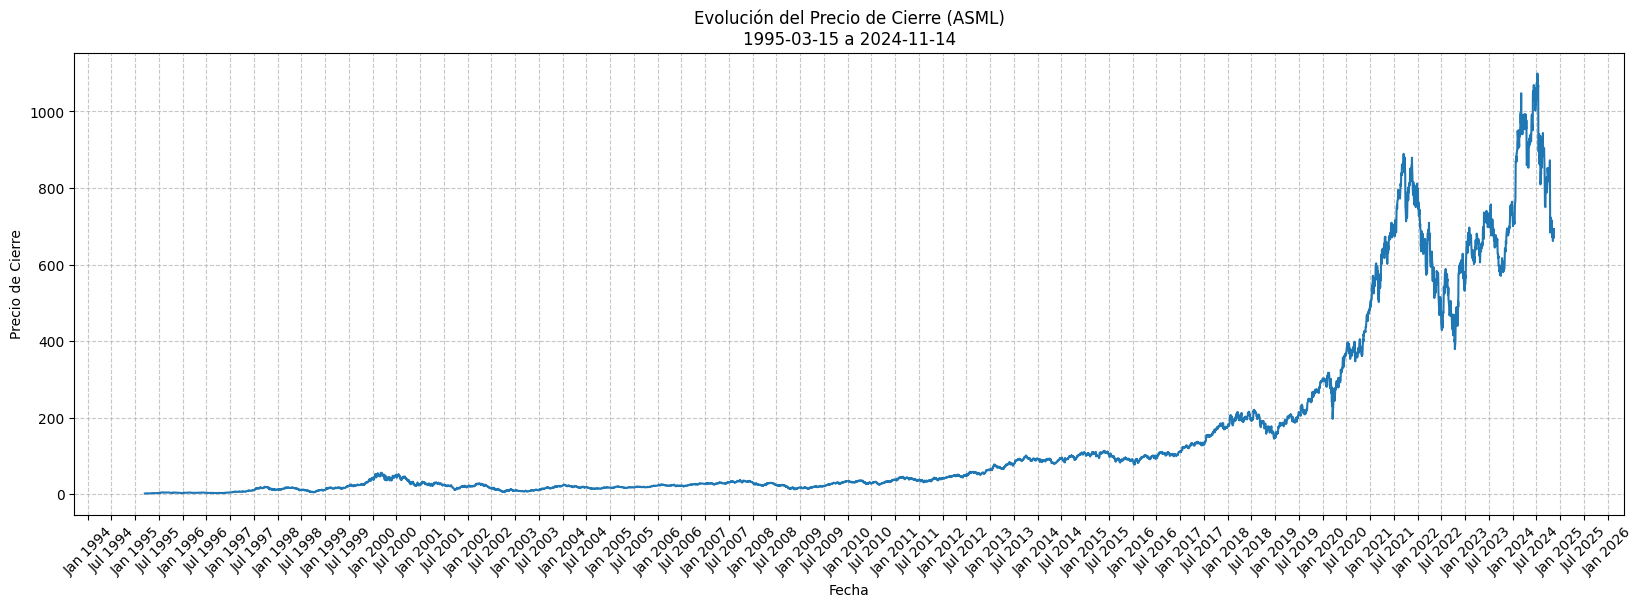


Procesando la acción: GOOGL


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Información de los datos para GOOGL:


,Date,Open,High,Low,Close,Adj Close,Volume
count,5096,5096.000000,5096.000000,5096.000000,5096.000000,5096.000000,5.096000e+03
mean,2014-10-01 20:30:02.825745664,47.082763,47.574156,46.597295,47.094334,46.984343,1.161269e+08
min,2004-08-19 00:00:00,2.482232,2.546046,2.401401,2.502753,2.496571,9.312000e+06
25%,2009-09-09 18:00:00,13.170546,13.273774,12.999312,13.157846,13.125345,3.072200e+07
50%,2014-10-01 12:00:00,27.914456,28.081910,27.685092,27.887763,27.818878,5.800490e+07
75%,2019-10-23 06:00:00,62.216500,62.711374,61.622876,62.166001,62.012447,1.398780e+08
max,2024-11-14 00:00:00,190.309998,191.750000,189.029999,191.179993,190.926636,1.643023e+09
std,NaN,45.036207,45.525303,44.574850,45.054092,44.959909,1.472291e+08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5096 entries, 0 to 5095
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5096 non-null   datetime64[ns]
 1   Open       5096 non-null   float64       
 2   High       5096 non-null   float64       
 3   Low        5096 non-null   float64       
 4   Close      5096 non-null   float64       
 5   Adj Close  5096 non-null   float64       
 6   Volume     5096 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 278.8 KB


None

C:\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Primeras filas del DataFrame:
        Date      Open      High       Low     Close  Adj Close     Volume
0 2004-08-19  2.502503  2.604104  2.401401  2.511011   2.504808  893181924
1 2004-08-20  2.527778  2.729730  2.515015  2.710460   2.703765  456686856
2 2004-08-23  2.771522  2.839840  2.728979  2.737738   2.730975  365122512
3 2004-08-24  2.783784  2.792793  2.591842  2.624374   2.617892  304946748
4 2004-08-25  2.626627  2.702703  2.599600  2.652653   2.646101  183772044

Últimas filas del DataFrame:
           Date        Open        High         Low       Close   Adj Close  \
5091 2024-11-08  180.649994  180.899994  178.080002  178.350006  178.350006   
5092 2024-11-11  178.580002  180.550003  178.470001  180.350006  180.350006   
5093 2024-11-12  179.820007  182.490005  179.389999  181.619995  181.619995   
5094 2024-11-13  180.460007  180.960007  178.539993  178.880005  178.880005   
5095 2024-11-14  178.279999  178.820007  174.320007  175.580002  175.580002   

        Volume 

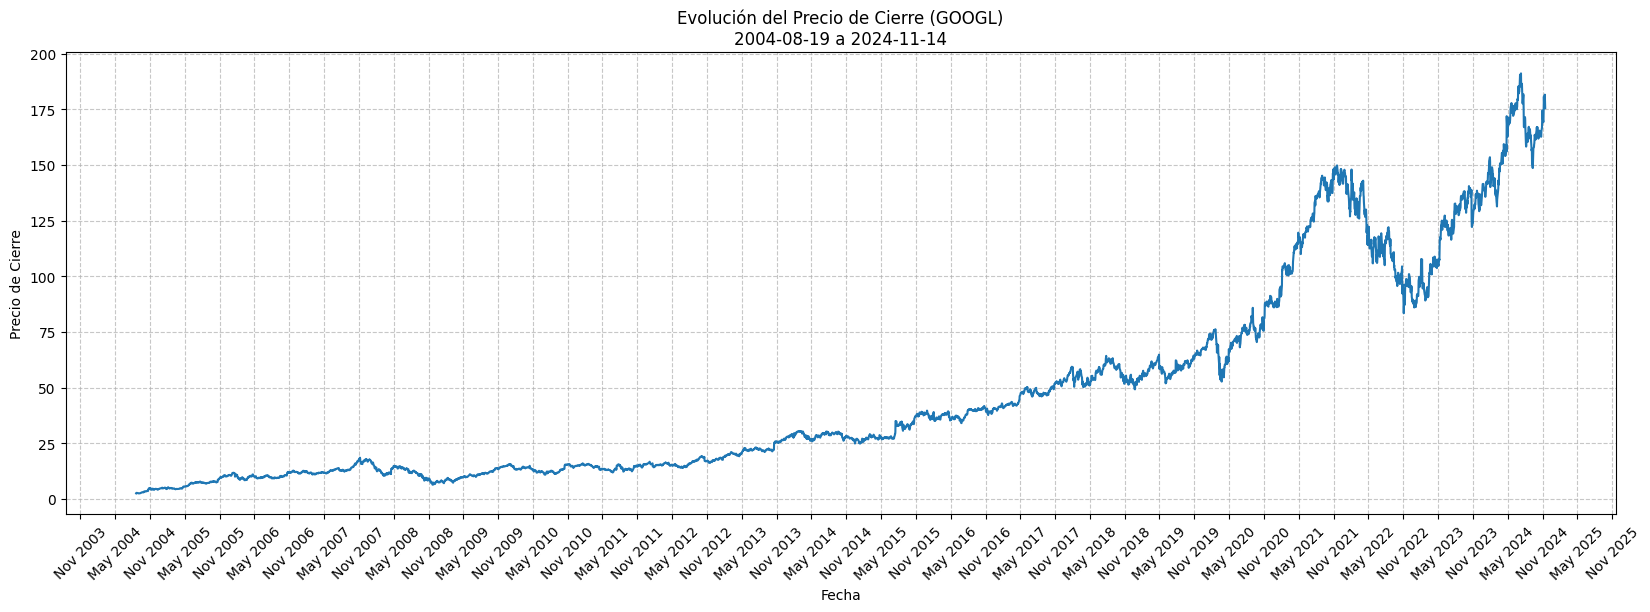


Procesando la acción: LRCX


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Información de los datos para LRCX:


,Date,Open,High,Low,Close,Adj Close,Volume
count,10216,10216.000000,10216.000000,10216.000000,10216.000000,10216.000000,1.021600e+04
mean,2004-08-02 16:03:42.709475200,10.196139,10.358265,10.029437,10.195570,7.583740,2.150046e+07
min,1984-05-04 00:00:00,0.072222,0.072222,0.066667,0.066667,0.029403,0.000000e+00
25%,1994-06-12 06:00:00,0.833333,0.858333,0.815973,0.838542,0.369829,9.187500e+06
50%,2004-08-02 12:00:00,2.783125,2.854000,2.724000,2.789500,1.230277,1.829400e+07
75%,2014-09-23 06:00:00,6.944500,7.054250,6.826000,6.936000,3.246526,2.900550e+07
max,2024-11-14 00:00:00,112.976997,113.000000,110.675003,112.730003,112.388153,2.987660e+08
std,NaN,19.198286,19.480210,18.891711,19.187456,17.299470,1.902555e+07


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10216 entries, 0 to 10215
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       10216 non-null  datetime64[ns]
 1   Open       10216 non-null  float64       
 2   High       10216 non-null  float64       
 3   Low        10216 non-null  float64       
 4   Close      10216 non-null  float64       
 5   Adj Close  10216 non-null  float64       
 6   Volume     10216 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 558.8 KB


None

C:\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Primeras filas del DataFrame:
        Date      Open      High       Low     Close  Adj Close    Volume
0 1984-05-04  0.222222  0.225000  0.222222  0.222222   0.098008  25789500
1 1984-05-07  0.222222  0.225000  0.219444  0.219444   0.096783   1026000
2 1984-05-08  0.219444  0.222222  0.219444  0.219444   0.096783   1372500
3 1984-05-09  0.219444  0.222222  0.219444  0.219444   0.096783   7416000
4 1984-05-10  0.219444  0.219444  0.213889  0.213889   0.094333   3037500

Últimas filas del DataFrame:
            Date       Open       High        Low      Close  Adj Close  \
10211 2024-11-08  78.830002  79.360001  77.470001  78.199997  78.199997   
10212 2024-11-11  77.430000  77.889999  74.849998  76.169998  76.169998   
10213 2024-11-12  76.419998  76.669998  74.660004  75.699997  75.699997   
10214 2024-11-13  74.500000  75.070000  73.510002  73.849998  73.849998   
10215 2024-11-14  75.449997  75.639999  74.500000  74.790001  74.790001   

         Volume  
10211   7527100  
10212  10

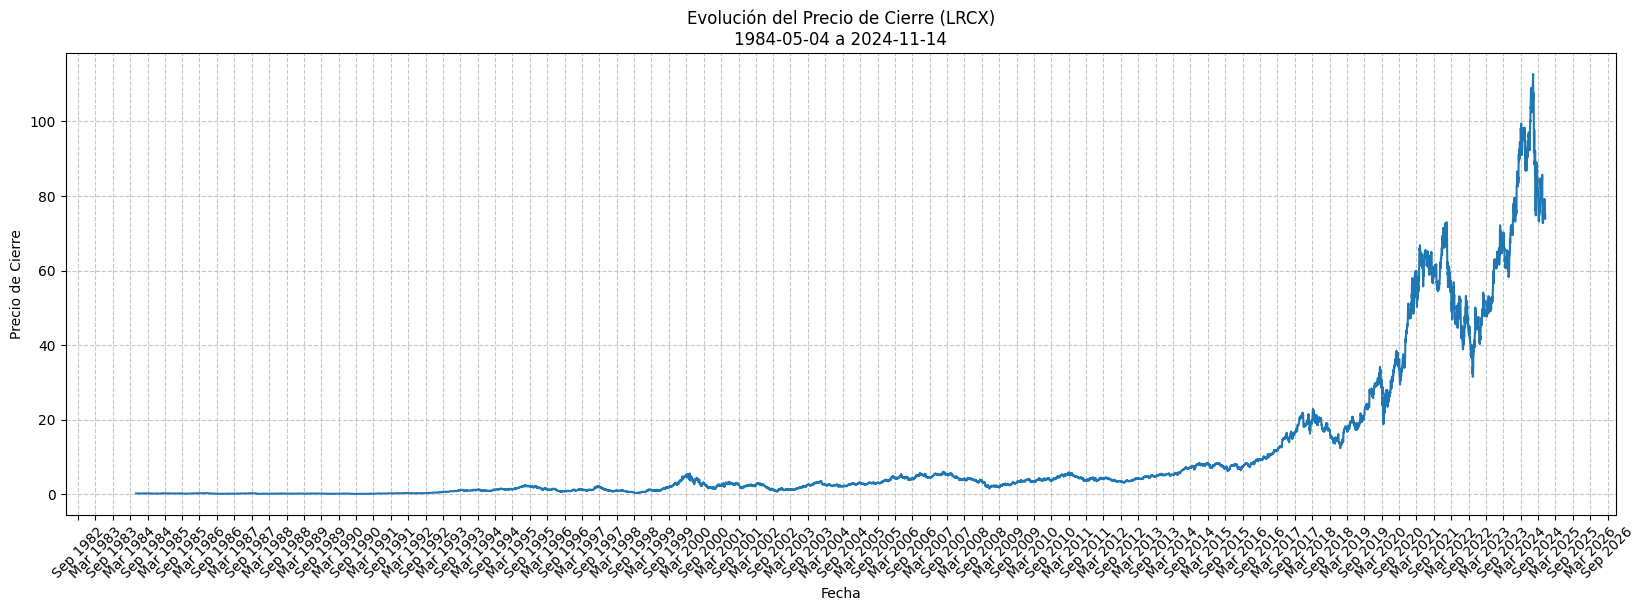

In [ ]:
# Lista de símbolos de acciones
acciones = ['TSM', 'ASML', 'GOOGL', 'LRCX']

# Procesar cada acción
for symbol in acciones:
    print(f"\nProcesando la acción: {symbol}")

    # Descargar datos
    df = descargar_datos_accion(symbol)

    # Mostrar información básica del DataFrame
    print(f"Información de los datos para {symbol}:")
    mostrar_informacion(df)

    # Graficar el precio de cierre
    print(f"Gráfica para {symbol}:")
    graficar_precio_cierre(df, symbol)

## Revisar la Data

Seleccionar las características y la variable objetivo

In [ ]:
def create_list_data(data, time_steps):
    """
    Crea secuencias temporales para entrenar un modelo LSTM o GRU.
    """
    x, y = [], []
    for i in range(len(data) - time_steps):
        x.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(x), np.array(y)

## GRU (Gated Recurrent Units) + Capa Densa

In [ ]:
from tensorflow.keras.layers import GRU
def entrenar_modelo_gru(df, symbol, time_steps=128, epochs=30, batch_size=32):
    """
    Entrena un modelo GRU para una acción específica.
    """
    # Escalar los datos
    close_prices = df['Close'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    close_prices_scaled = scaler.fit_transform(close_prices)

    # Crear datos para el modelo
    x_total, y_total = create_list_data(close_prices_scaled, time_steps)
    dis = int(len(x_total) * 0.8)
    x_train, x_test = x_total[:dis], x_total[dis:]
    y_train, y_test = y_total[:dis], y_total[dis:]

    # Redimensionar para la entrada del modelo
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Definir el modelo
    model = Sequential([
        GRU(units=64, return_sequences=True, input_shape=(x_train.shape[1], 1)),
        GRU(units=128),
        Dense(units=25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

    # Entrenar el modelo
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(x_test, y_test),
                        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

    # Evaluar el modelo
    test_loss = model.evaluate(x_test, y_test)
    predictions = model.predict(x_test)

    # Desescalar los valores
    predictions = scaler.inverse_transform(predictions)
    y_test = y_test.reshape(-1, 1)
    y_test = scaler.inverse_transform(y_test)

    # Calcular métricas
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)

    print(f"Resultados para {symbol}:")
    print(f"Test Loss (MSE): {test_loss[0]}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared (R²): {r2}")

    # Guardar el modelo
    model.save(f"GRU_{symbol}.keras")

    # Generar gráficos
    plt.figure(figsize=(14, 7))
    plt.plot(y_test, label='Valores Reales', color='blue', alpha=0.7)
    plt.plot(predictions, label='Predicciones', color='red', alpha=0.7)
    plt.title(f"Predicciones vs Valores Reales para {symbol}")
    plt.xlabel('Índice')
    plt.ylabel('Precio de Cierre')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"Comparacion_{symbol}.png")
    plt.show()

    plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de validación')
    plt.title(f"Evolución de la pérdida para {symbol}")
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"Perdida_{symbol}.png")
    plt.show()

    return model



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - loss: 6.5484e-04 - mean_absolute_error: 0.0132 - val_loss: 3.0569e-04 - val_mean_absolute_error: 0.0123
Epoch 2/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - loss: 7.2642e-06 - mean_absolute_error: 0.0019 - val_loss: 3.5092e-04 - val_mean_absolute_error: 0.0133
Epoch 3/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - loss: 8.7784e-06 - mean_absolute_error: 0.0022 - val_loss: 2.5887e-04 - val_mean_absolute_error: 0.0114
Epoch 4/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - loss: 6.9830e-06 - mean_absolute_error: 0.0019 - val_loss: 2.3988e-04 - val_mean_absolute_error: 0.0110
Epoch 5/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - loss: 9.0907e-06 - mean_absolute_error: 0.0022 - val_loss: 2.3148e-04 - val_mean_absolute_error: 0.0108
Epoch 6/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - loss: 6.5769e-06 - mean_absolute_error: 0.0018 - val_loss: 2.2089e-04 - val_mean_absolute_error: 0.0105
Epoch 7/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 

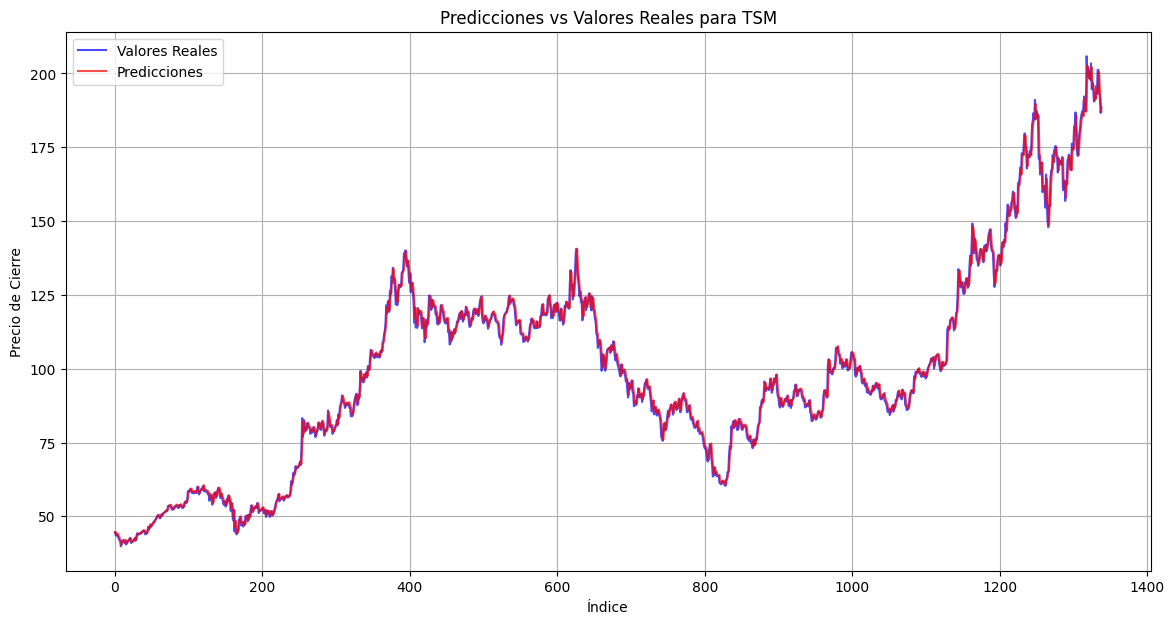

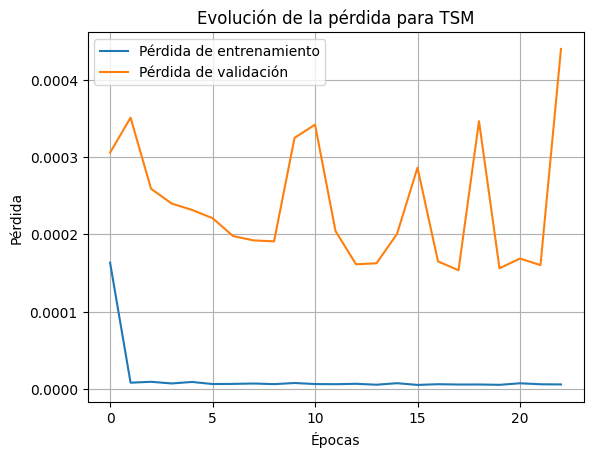

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Epoch 1/30



C:\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


184/184 ━━━━━━━━━━━━━━━━━━━━ 17s 81ms/step - loss: 3.4135e-04 - mean_absolute_error: 0.0097 - val_loss: 3.9397e-04 - val_mean_absolute_error: 0.0137
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - loss: 4.0914e-06 - mean_absolute_error: 0.0013 - val_loss: 5.0524e-04 - val_mean_absolute_error: 0.0165
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - loss: 4.4141e-06 - mean_absolute_error: 0.0014 - val_loss: 6.2381e-04 - val_mean_absolute_error: 0.0190
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - loss: 4.2449e-06 - mean_absolute_error: 0.0014 - val_loss: 5.2256e-04 - val_mean_absolute_error: 0.0171
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - loss: 3.6989e-06 - mean_absolute_error: 0.0013 - val_loss: 3.2713e-04 - val_mean_absolute_error: 0.0123
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - loss: 4.0022e-06 - mean_absolute_error: 0.0014 - val_loss: 8.2187e-04 - val_mean_absolute_error: 0.0228
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/st

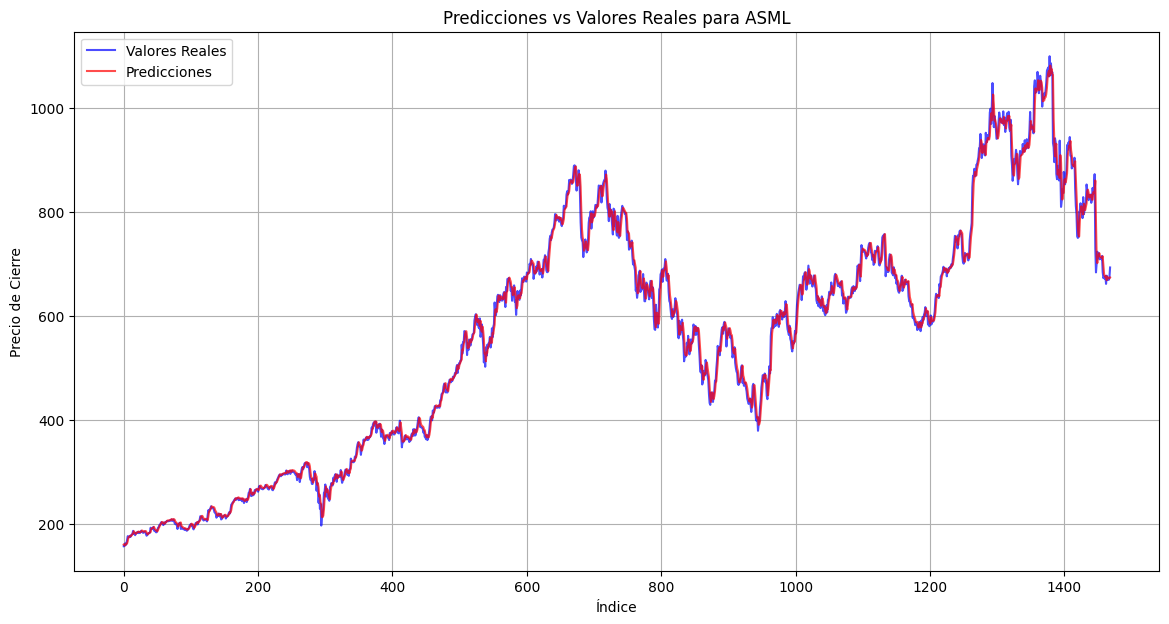

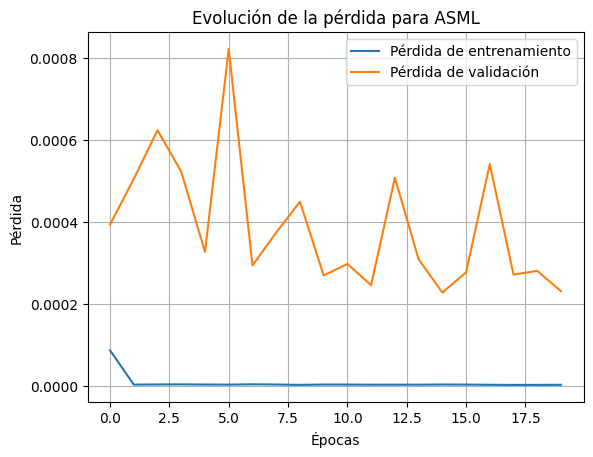

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Epoch 1/30



C:\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - loss: 0.0035 - mean_absolute_error: 0.0329 - val_loss: 4.0872e-04 - val_mean_absolute_error: 0.0162
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 1.8187e-05 - mean_absolute_error: 0.0027 - val_loss: 2.9839e-04 - val_mean_absolute_error: 0.0132
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 2.0198e-05 - mean_absolute_error: 0.0029 - val_loss: 2.8610e-04 - val_mean_absolute_error: 0.0130
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 1.9824e-05 - mean_absolute_error: 0.0029 - val_loss: 3.9825e-04 - val_mean_absolute_error: 0.0155
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 2.2956e-05 - mean_absolute_error: 0.0032 - val_loss: 2.5992e-04 - val_mean_absolute_error: 0.0122
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - loss: 1.9275e-05 - mean_absolute_error: 0.0030 - val_loss: 2.4635e-04 - val_mean_absolute_error: 0.0120
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step -

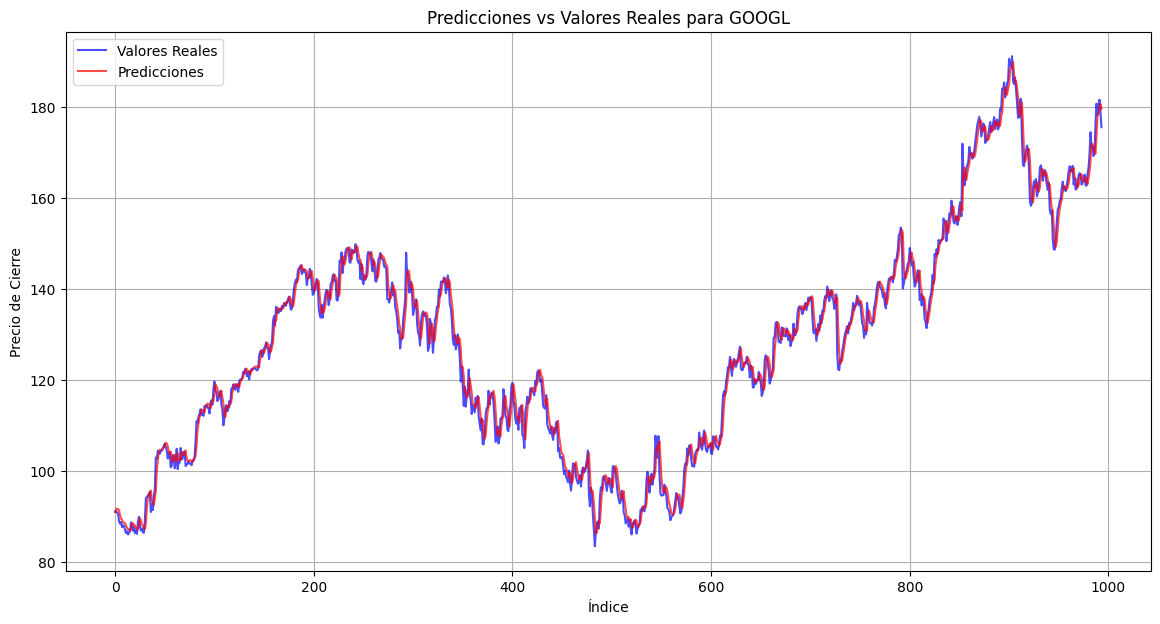

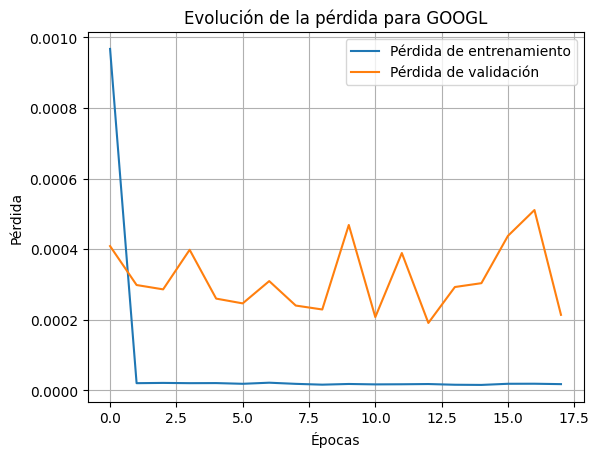

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Epoch 1/30



C:\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


253/253 ━━━━━━━━━━━━━━━━━━━━ 24s 84ms/step - loss: 8.6307e-05 - mean_absolute_error: 0.0042 - val_loss: 2.7069e-04 - val_mean_absolute_error: 0.0111
Epoch 2/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - loss: 1.5706e-06 - mean_absolute_error: 9.2389e-04 - val_loss: 2.5166e-04 - val_mean_absolute_error: 0.0107
Epoch 3/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - loss: 1.6206e-06 - mean_absolute_error: 9.3356e-04 - val_loss: 2.6544e-04 - val_mean_absolute_error: 0.0112
Epoch 4/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - loss: 1.6410e-06 - mean_absolute_error: 9.5718e-04 - val_loss: 2.4797e-04 - val_mean_absolute_error: 0.0107
Epoch 5/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - loss: 1.3692e-06 - mean_absolute_error: 8.4642e-04 - val_loss: 3.2575e-04 - val_mean_absolute_error: 0.0127
Epoch 6/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - loss: 1.8278e-06 - mean_absolute_error: 0.0010 - val_loss: 4.6620e-04 - val_mean_absolute_error: 0.0160
Epoch 7/30
253/253 ━━━━━━━━━━━━━━━━

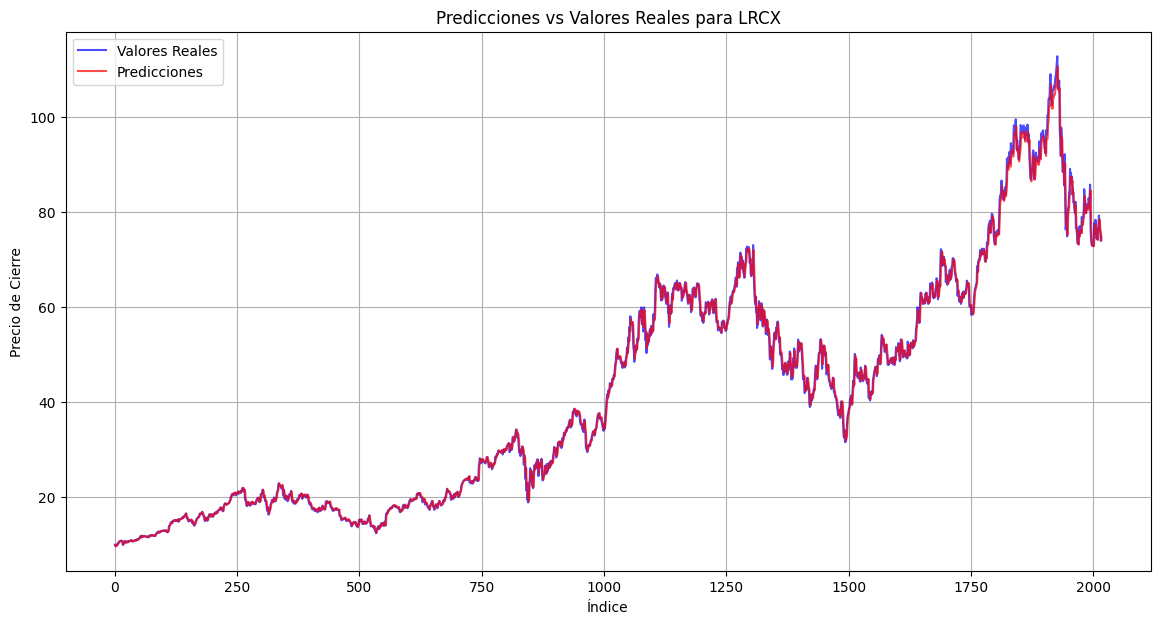

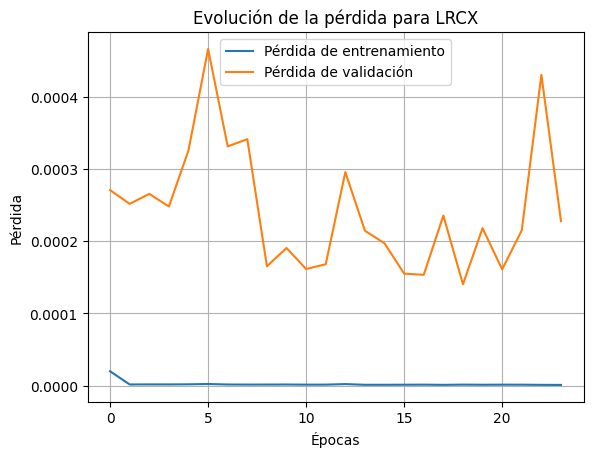

In [ ]:
# Entrenar modelo para cada acción
symbols = ['TSM', 'ASML', 'GOOGL', 'LRCX']
for symbol in symbols:
    df = descargar_datos_accion(symbol)
    model = entrenar_modelo_gru(df, symbol)

Predicciones para TSM:


[*********************100%%**********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
       Fecha  Predicción
0 2024-11-18  186.110092
1 2024-11-19  185.892624
2 2024-11-20  185.684067


[*********************100%%**********************]  1 of 1 completed


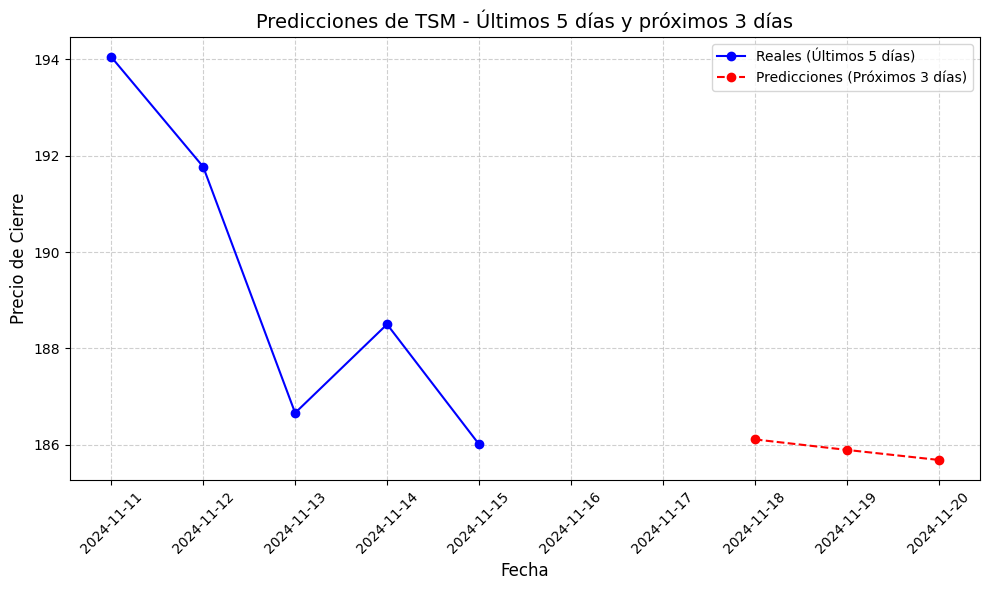

Predicciones para ASML:


[*********************100%%**********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
       Fecha  Predicción
0 2024-11-18  671.317139
1 2024-11-19  671.282104
2 2024-11-20  672.358154


[*********************100%%**********************]  1 of 1 completed


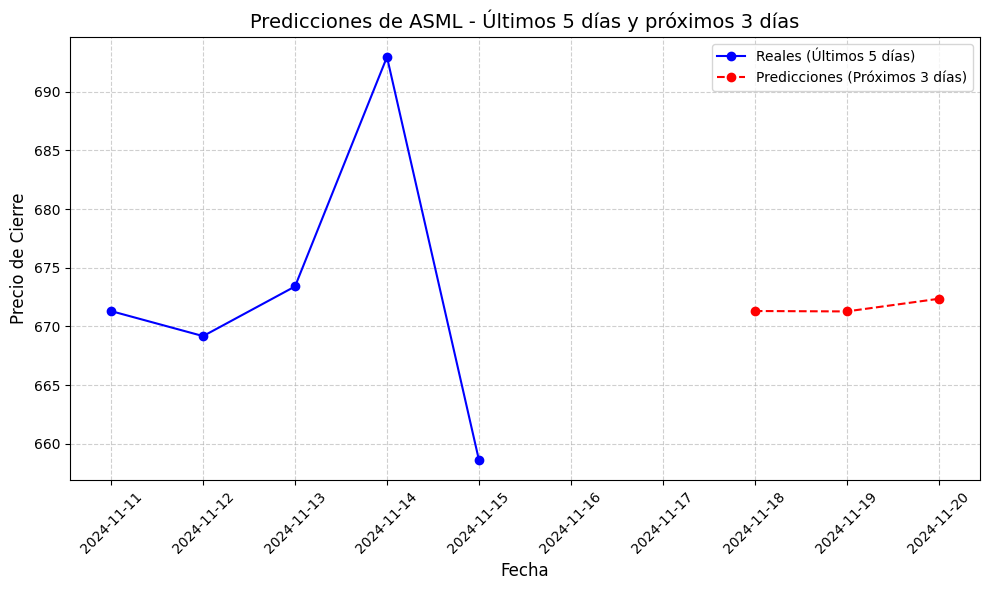

Predicciones para GOOGL:


[*********************100%%**********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
       Fecha  Predicción
0 2024-11-18  174.083374
1 2024-11-19  173.737686
2 2024-11-20  173.609558


[*********************100%%**********************]  1 of 1 completed


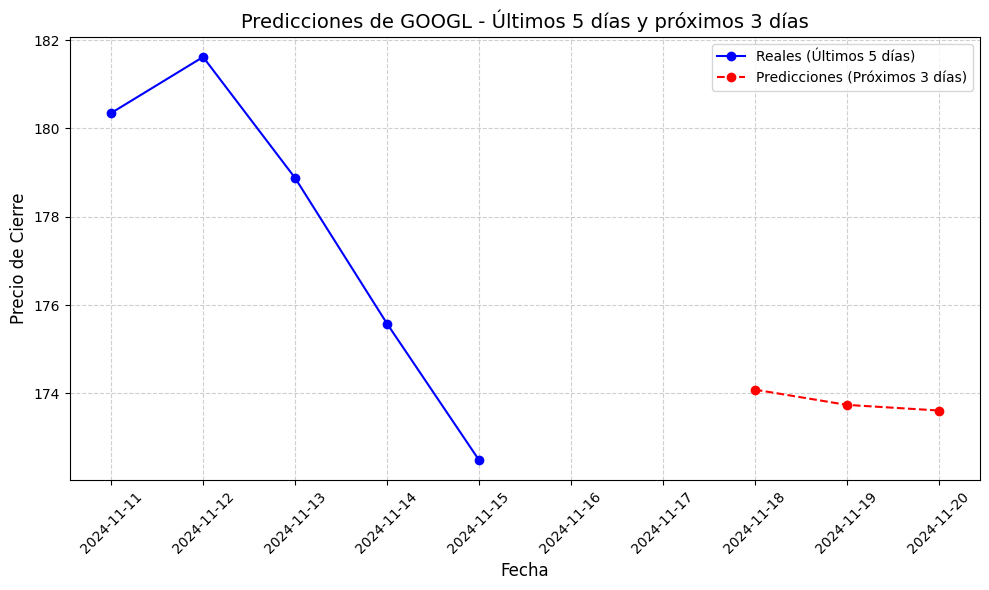

Predicciones para LRCX:


[*********************100%%**********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
       Fecha  Predicción
0 2024-11-18   70.836044
1 2024-11-19   70.703041
2 2024-11-20   70.616150


[*********************100%%**********************]  1 of 1 completed


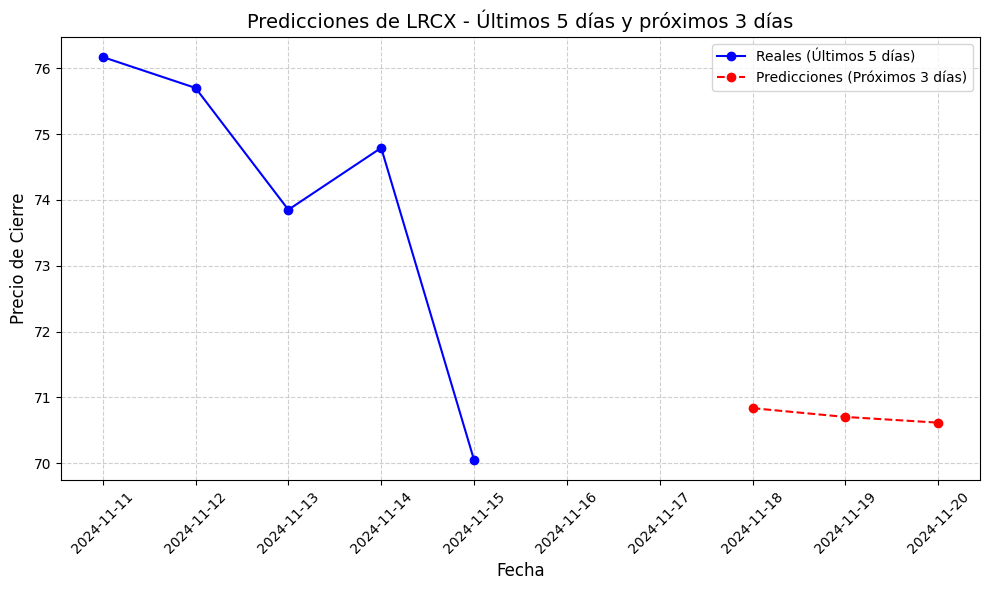

In [ ]:
from tensorflow.keras.models import load_model

def cargar_datos_y_scaler(symbol):
    """
    Descarga los datos de una acción y ajusta el escalador basado en los precios de cierre.
    """
    df = yf.download(symbol, period="max", interval='1d')
    close_prices = df['Close'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    close_prices_scaled = scaler.fit_transform(close_prices)
    return df, close_prices, close_prices_scaled, scaler

def predecir_siguientes_dias(symbol, modelo_path, dias_a_predecir=3, time_steps=128):
    """
    Carga el modelo guardado y predice los precios de cierre para los próximos días.
    """
    # Cargar datos y escalador
    df, close_prices, close_prices_scaled, scaler = cargar_datos_y_scaler(symbol)

    # Cargar el modelo
    model = load_model(modelo_path)

    # Preparar la secuencia inicial
    last_sequence = close_prices_scaled[-time_steps:]
    predictions_scaled = []

    for _ in range(dias_a_predecir):
        # Hacer predicción para el siguiente día
        pred_scaled = model.predict(last_sequence.reshape(1, time_steps, 1))
        predictions_scaled.append(pred_scaled[0][0])

        # Actualizar la secuencia con la predicción
        last_sequence = np.append(last_sequence[1:], pred_scaled, axis=0)

    # Desescalar las predicciones
    predictions = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1))

    # Crear un DataFrame para mostrar las predicciones
    last_date = df.index[-1]
    prediction_dates = pd.date_range(start=last_date, periods=dias_a_predecir + 1, freq='B')[1:]
    pred_df = pd.DataFrame({'Fecha': prediction_dates, 'Predicción': predictions.flatten()})

    return pred_df

def graficar_predicciones(symbol, df, predictions, dias_a_predecir=3):
    """
    Genera un gráfico con los últimos 5 días reales y los días predichos.
    """
    # Obtener los últimos 5 días reales
    real_dates = df.index[-5:]
    real_prices = df['Close'].values[-5:]

    # Combinar datos reales y predichos
    prediction_dates = predictions['Fecha']
    prediction_prices = predictions['Predicción'].values

    # Crear el gráfico
    plt.figure(figsize=(10, 6))
    plt.plot(real_dates, real_prices, label='Reales (Últimos 5 días)', color='blue', marker='o')
    plt.plot(prediction_dates, prediction_prices, label='Predicciones (Próximos 3 días)', color='red', marker='o', linestyle='--')

    # Configurar el gráfico
    plt.title(f"Predicciones de {symbol} - Últimos 5 días y próximos {dias_a_predecir} días", fontsize=14)
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Precio de Cierre', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Lista de acciones y rutas de los modelos
symbols = ['TSM', 'ASML', 'GOOGL', 'LRCX']
models_paths = {symbol: f"GRU_{symbol}.keras" for symbol in symbols}

# Predicción para cada acción
for symbol in symbols:
    print(f"Predicciones para {symbol}:")
    pred_df = predecir_siguientes_dias(symbol, models_paths[symbol])
    print(pred_df)
    graficar_predicciones(symbol, cargar_datos_y_scaler(symbol)[0], pred_df)

Mostrando dashboard para TSM:


[*********************100%%**********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


[*********************100%%**********************]  1 of 1 completed


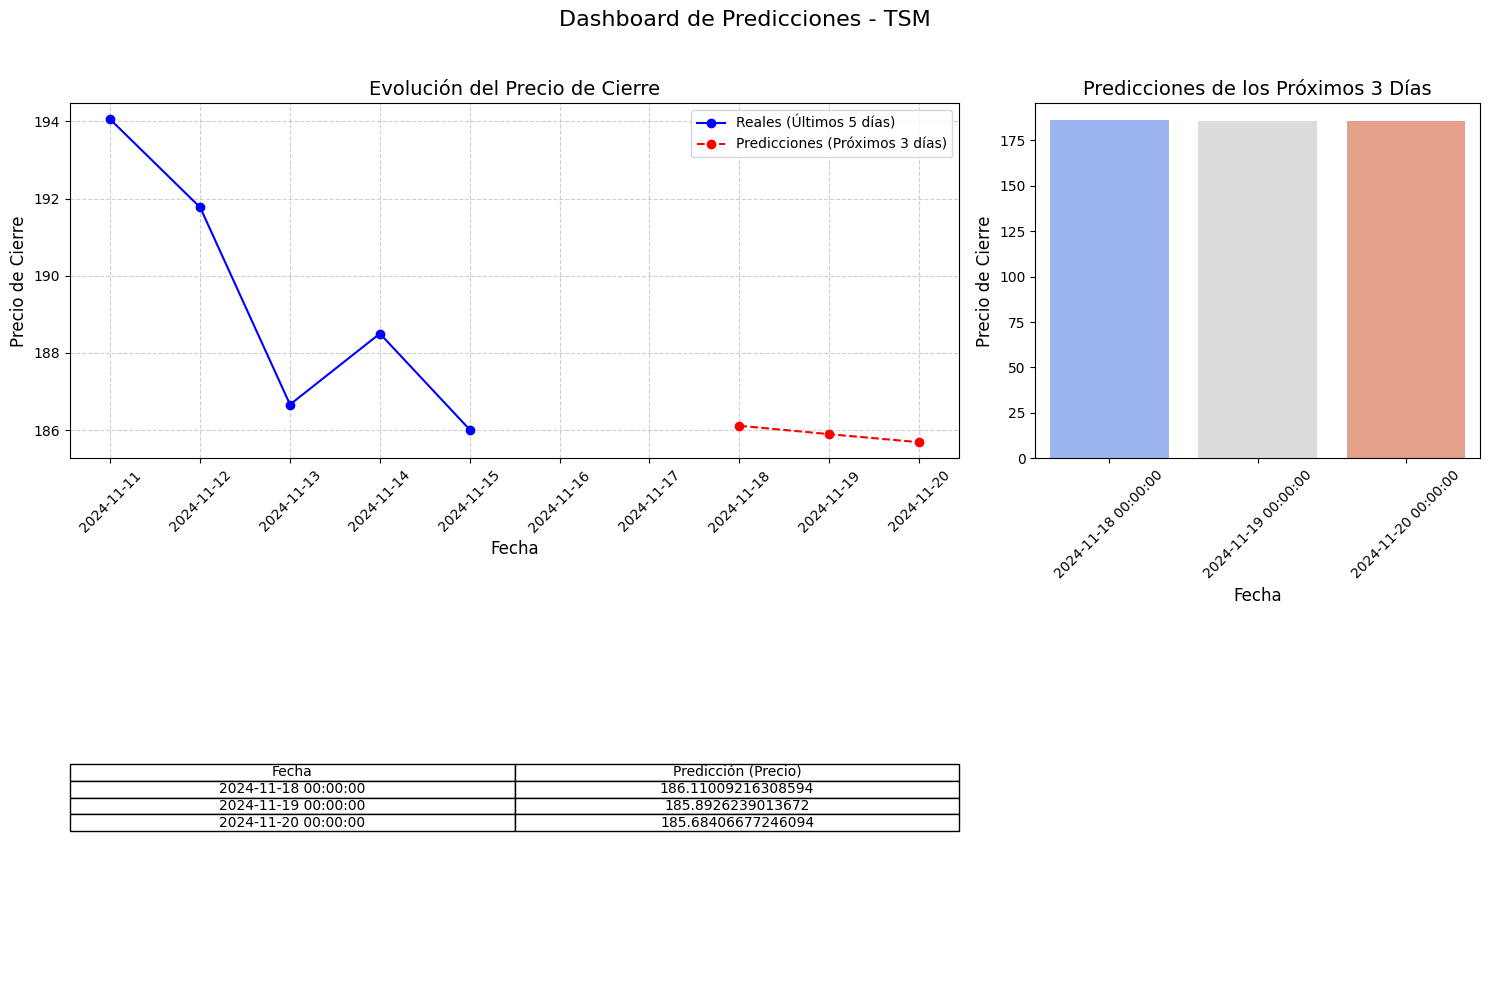

Mostrando dashboard para ASML:


[*********************100%%**********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


[*********************100%%**********************]  1 of 1 completed


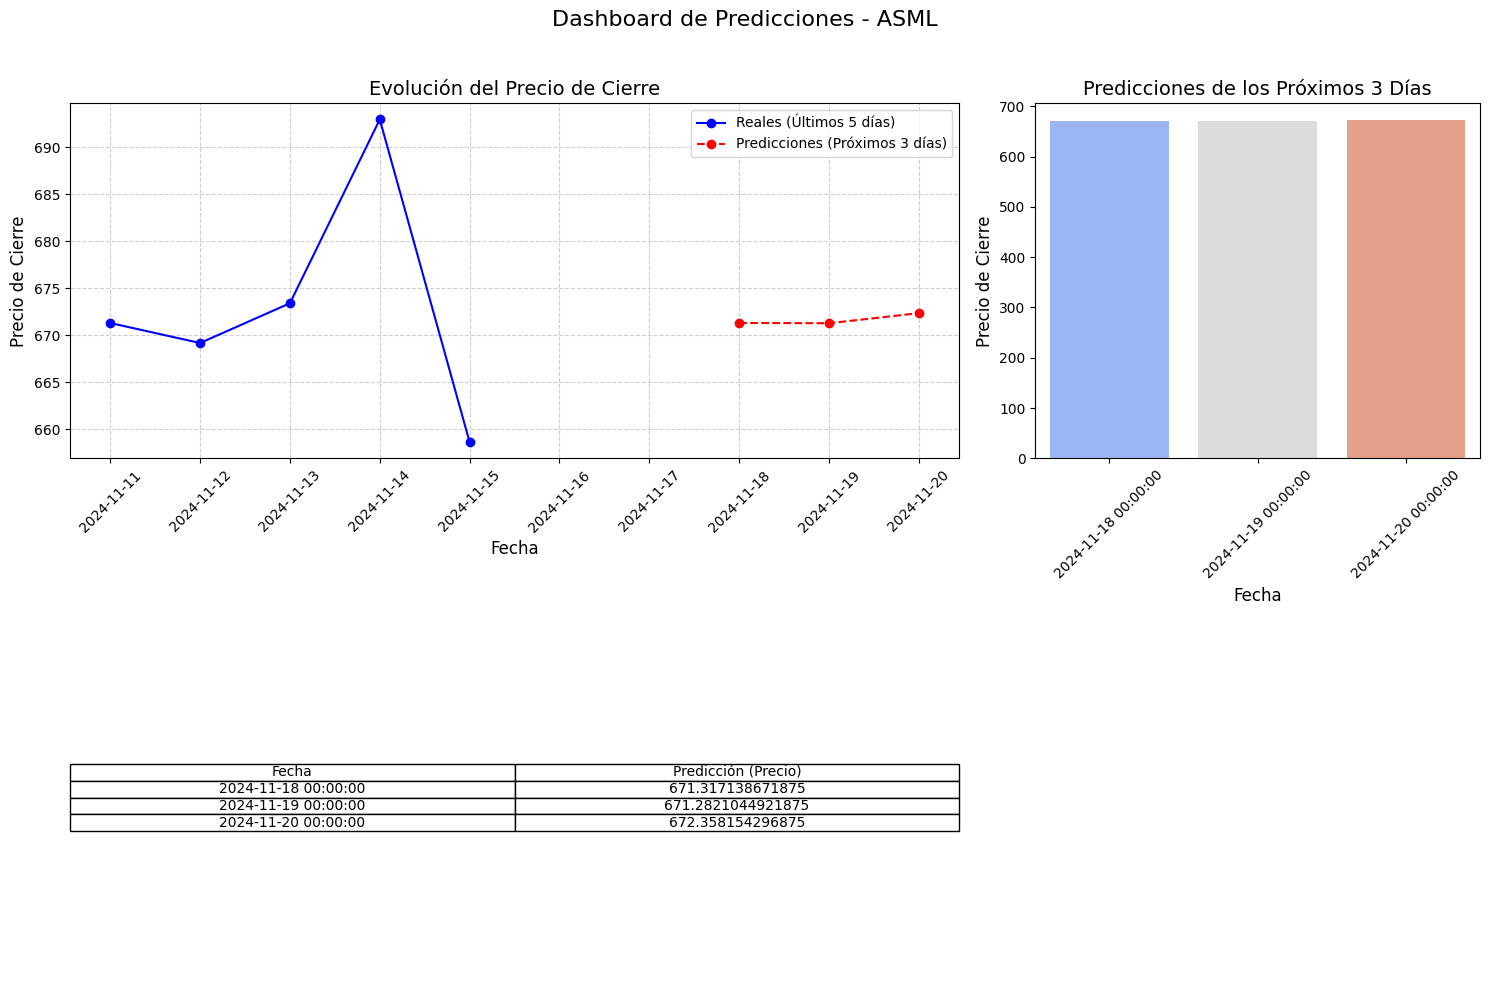

Mostrando dashboard para GOOGL:


[*********************100%%**********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


[*********************100%%**********************]  1 of 1 completed


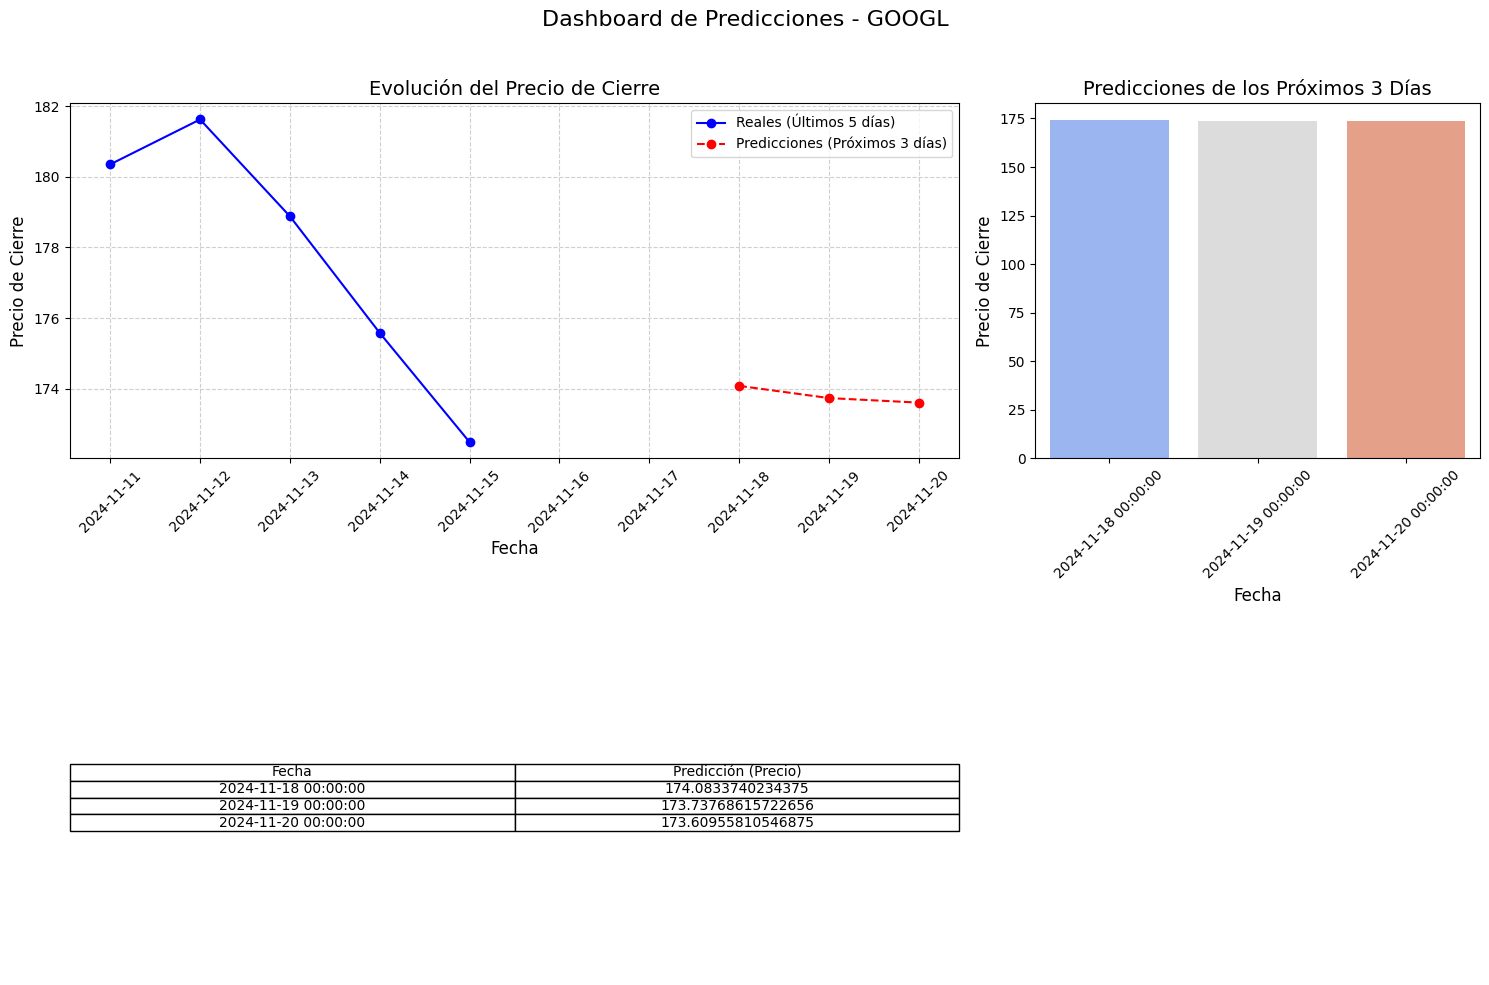

Mostrando dashboard para LRCX:


[*********************100%%**********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


[*********************100%%**********************]  1 of 1 completed


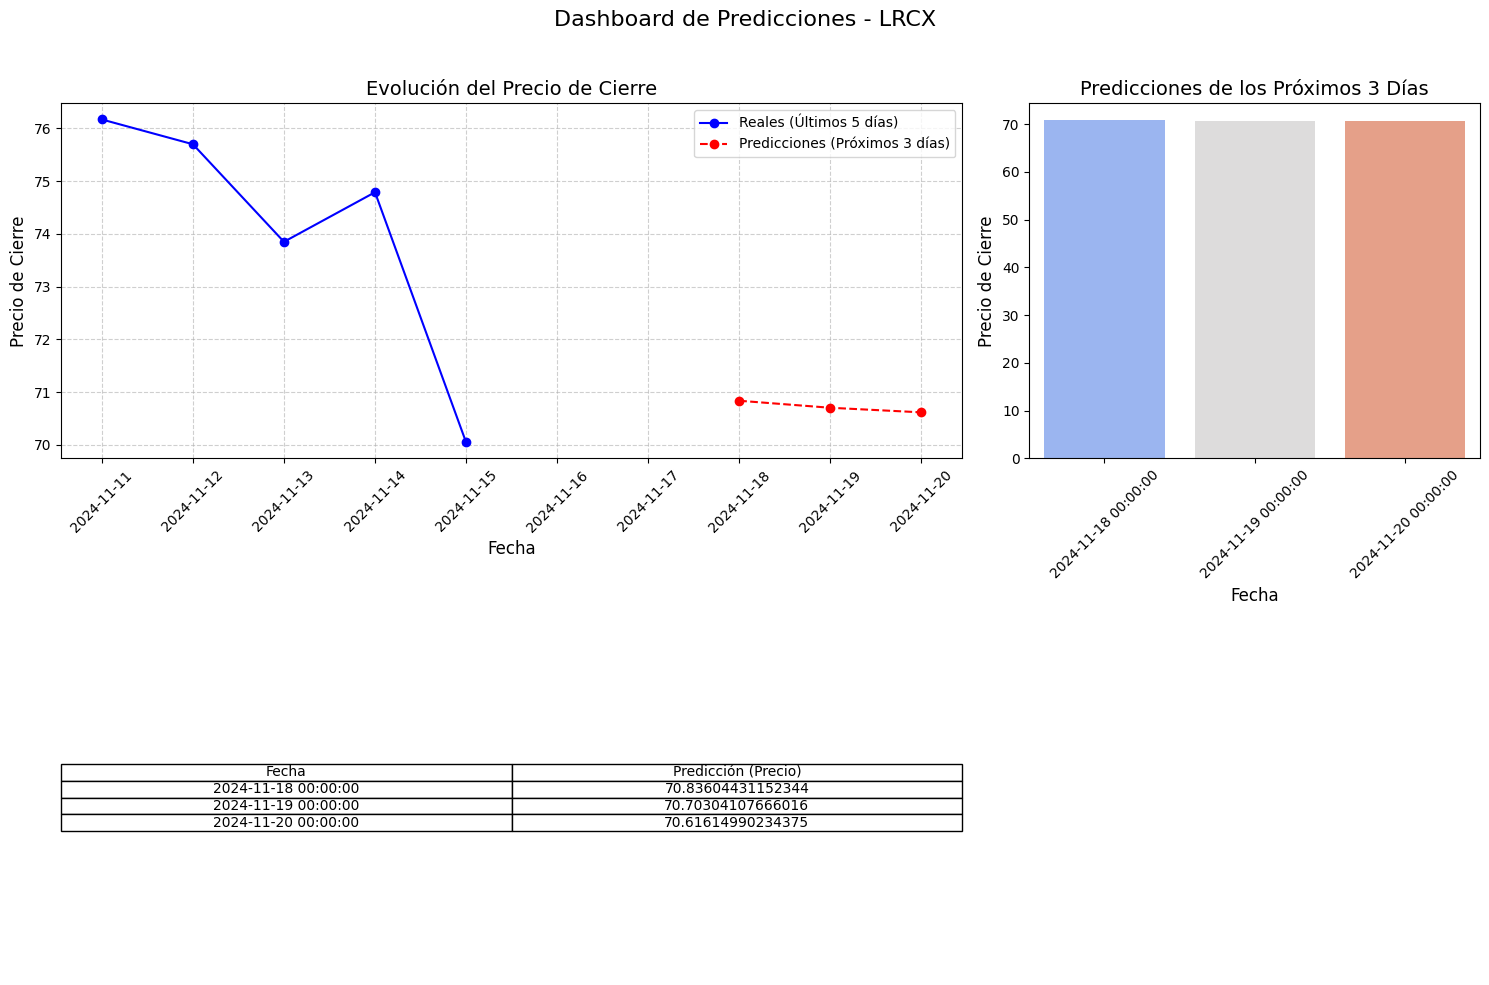

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def mostrar_dashboard(symbol, df, predictions, dias_a_predecir=3):
    """
    Genera un dashboard para mostrar los últimos 5 días reales y los días predichos.
    """
    # Últimos 5 días reales
    real_dates = df.index[-5:]
    real_prices = df['Close'].values[-5:]

    # Fechas y valores predichos
    prediction_dates = predictions['Fecha']
    prediction_prices = predictions['Predicción'].values

    # Preparar datos combinados para tabla
    tabla_predicciones = pd.DataFrame({
        'Fecha': prediction_dates,
        'Predicción (Precio)': prediction_prices
    })

    # Crear la figura del dashboard
    fig, ax = plt.subplots(2, 2, figsize=(15, 10), gridspec_kw={'width_ratios': [2, 1]})
    fig.suptitle(f"Dashboard de Predicciones - {symbol}", fontsize=16)

    # Gráfico 1: Últimos 5 días y predicciones
    ax[0, 0].plot(real_dates, real_prices, label='Reales (Últimos 5 días)', color='blue', marker='o')
    ax[0, 0].plot(prediction_dates, prediction_prices, label='Predicciones (Próximos 3 días)', color='red', marker='o', linestyle='--')
    ax[0, 0].set_title('Evolución del Precio de Cierre', fontsize=14)
    ax[0, 0].set_xlabel('Fecha', fontsize=12)
    ax[0, 0].set_ylabel('Precio de Cierre', fontsize=12)
    ax[0, 0].legend()
    ax[0, 0].grid(True, linestyle='--', alpha=0.6)
    ax[0, 0].tick_params(axis='x', rotation=45)

    # Gráfico 2: Gráfico de barras de predicciones
    sns.barplot(x=prediction_dates, y=prediction_prices, ax=ax[0, 1], palette='coolwarm')
    ax[0, 1].set_title('Predicciones de los Próximos 3 Días', fontsize=14)
    ax[0, 1].set_xlabel('Fecha', fontsize=12)
    ax[0, 1].set_ylabel('Precio de Cierre', fontsize=12)
    ax[0, 1].tick_params(axis='x', rotation=45)

    # Tabla de predicciones
    ax[1, 0].axis('tight')
    ax[1, 0].axis('off')
    ax[1, 0].table(cellText=tabla_predicciones.values, colLabels=tabla_predicciones.columns, loc='center', cellLoc='center', colLoc='center')

    # Espacio vacío para estética
    ax[1, 1].axis('off')

    # Ajustar el diseño
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Ejemplo de integración en el flujo
for symbol in symbols:
    print(f"Mostrando dashboard para {symbol}:")
    pred_df = predecir_siguientes_dias(symbol, models_paths[symbol])
    mostrar_dashboard(symbol, cargar_datos_y_scaler(symbol)[0], pred_df)